In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import numpy as np
import pandas
import cv2
import matplotlib.pyplot as plt
import csv
import random
from skimage.transform import rotate
import joblib
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

#### Class names

In [3]:
class_names = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield",
    14: "Stop", 15: "No vehicles", 16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve to the left",
    20: "Dangerous curve to the right", 21: "Double curve", 22: "Bumpy road",
    23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left",
    40: "Roundabout mandatory", 41: "End of no passing",
    42: "End of no passing for vehicles over 3.5 metric tons"
}

#### Load Data

In [4]:
augmented_I_RGB = np.load('augmented_I_RGB.npy')      # Shape: (N, 32, 32, 3)
augmented_I_Gray = np.load('augmented_I_Gray.npy')    # Shape: (N, 32, 32)
augmented_L = np.load('augmented_L.npy')              # Shape: (N,)

#Verify shapes
print(f"RGB images: {augmented_I_RGB.shape}")
print(f"Grayscale images: {augmented_I_Gray.shape}")
print(f"Labels: {augmented_L.shape}")

RGB images: (78418, 32, 32, 3)
Grayscale images: (78418, 32, 32)
Labels: (78418,)


#### Simple CNN

In [5]:
model = models.Sequential()
#in
model.add(layers.InputLayer(input_shape=(32, 32,1)))
#Convolutional Block 1
model.add(layers.Conv2D(64, (5, 5), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.LayerNormalization())

# Conv Block 2
model.add(layers.Conv2D(128, (5, 5), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.LayerNormalization())
    
# Conv block 3
model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.LayerNormalization())

# Output block
model.add(layers.Flatten())
model.add(layers.Dense(43, activation='softmax'))

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
X = augmented_I_Gray
y = augmented_L  
print(len(X),len(y))

78418 78418


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
y_train_int = np.array(y_train).astype(int)
y_train_onehot = to_categorical(y_train_int, num_classes=43)

In [9]:
early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
)

In [10]:
history = model.fit(
    X_train, y_train_onehot,
    epochs=50,  # Set high since we're using early stopping
    batch_size=32,
    callbacks=[early_stopping],
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
1569/1569 [==============================] - 13s 7ms/step - loss: 0.8175 - accuracy: 0.7834 - val_loss: 0.1050 - val_accuracy: 0.9668
Epoch 2/50
1569/1569 [==============================] - 10s 6ms/step - loss: 0.0403 - accuracy: 0.9888 - val_loss: 0.0230 - val_accuracy: 0.9930
Epoch 3/50
1569/1569 [==============================] - 10s 6ms/step - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.0497 - val_accuracy: 0.9846
Epoch 4/50
1569/1569 [==============================] - 10s 6ms/step - loss: 0.0158 - accuracy: 0.9950 - val_loss: 0.0159 - val_accuracy: 0.9956
Epoch 5/50
1569/1569 [==============================] - 10s 6ms/step - loss: 0.0132 - accuracy: 0.9959 - val_loss: 0.0144 - val_accuracy: 0.9955
Epoch 6/50
1569/1569 [==============================] - 9s 6ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.0272 - val_accuracy: 0.9916
Epoch 7/50
1569/1569 [==============================] - 10s 6ms/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 0.0330 - val_acc

#### Evaluation


                 TRAINING METRICS                 
Training Accuracy:       0.9995
Training Loss:           0.0016

                   TEST METRICS                   
Test Accuracy:           0.9979
Test Loss:               0.0086
Precision:               0.9979
Recall:                  0.9979
F1-Score:                0.9979


          DETAILED CLASSIFICATION REPORT          
              precision    recall  f1-score   support

           0     1.0000    0.9881    0.9940        84
           1     0.9989    0.9966    0.9977       888
           2     1.0000    1.0000    1.0000       900
           3     0.9982    0.9982    0.9982       564
           4     0.9975    1.0000    0.9987       792
           5     0.9987    0.9973    0.9980       744
           6     1.0000    1.0000    1.0000       168
           7     0.9931    1.0000    0.9965       576
           8     1.0000    0.9982    0.9991       564
           9     0.9983    0.9966    0.9974       588
          10     1.0000 

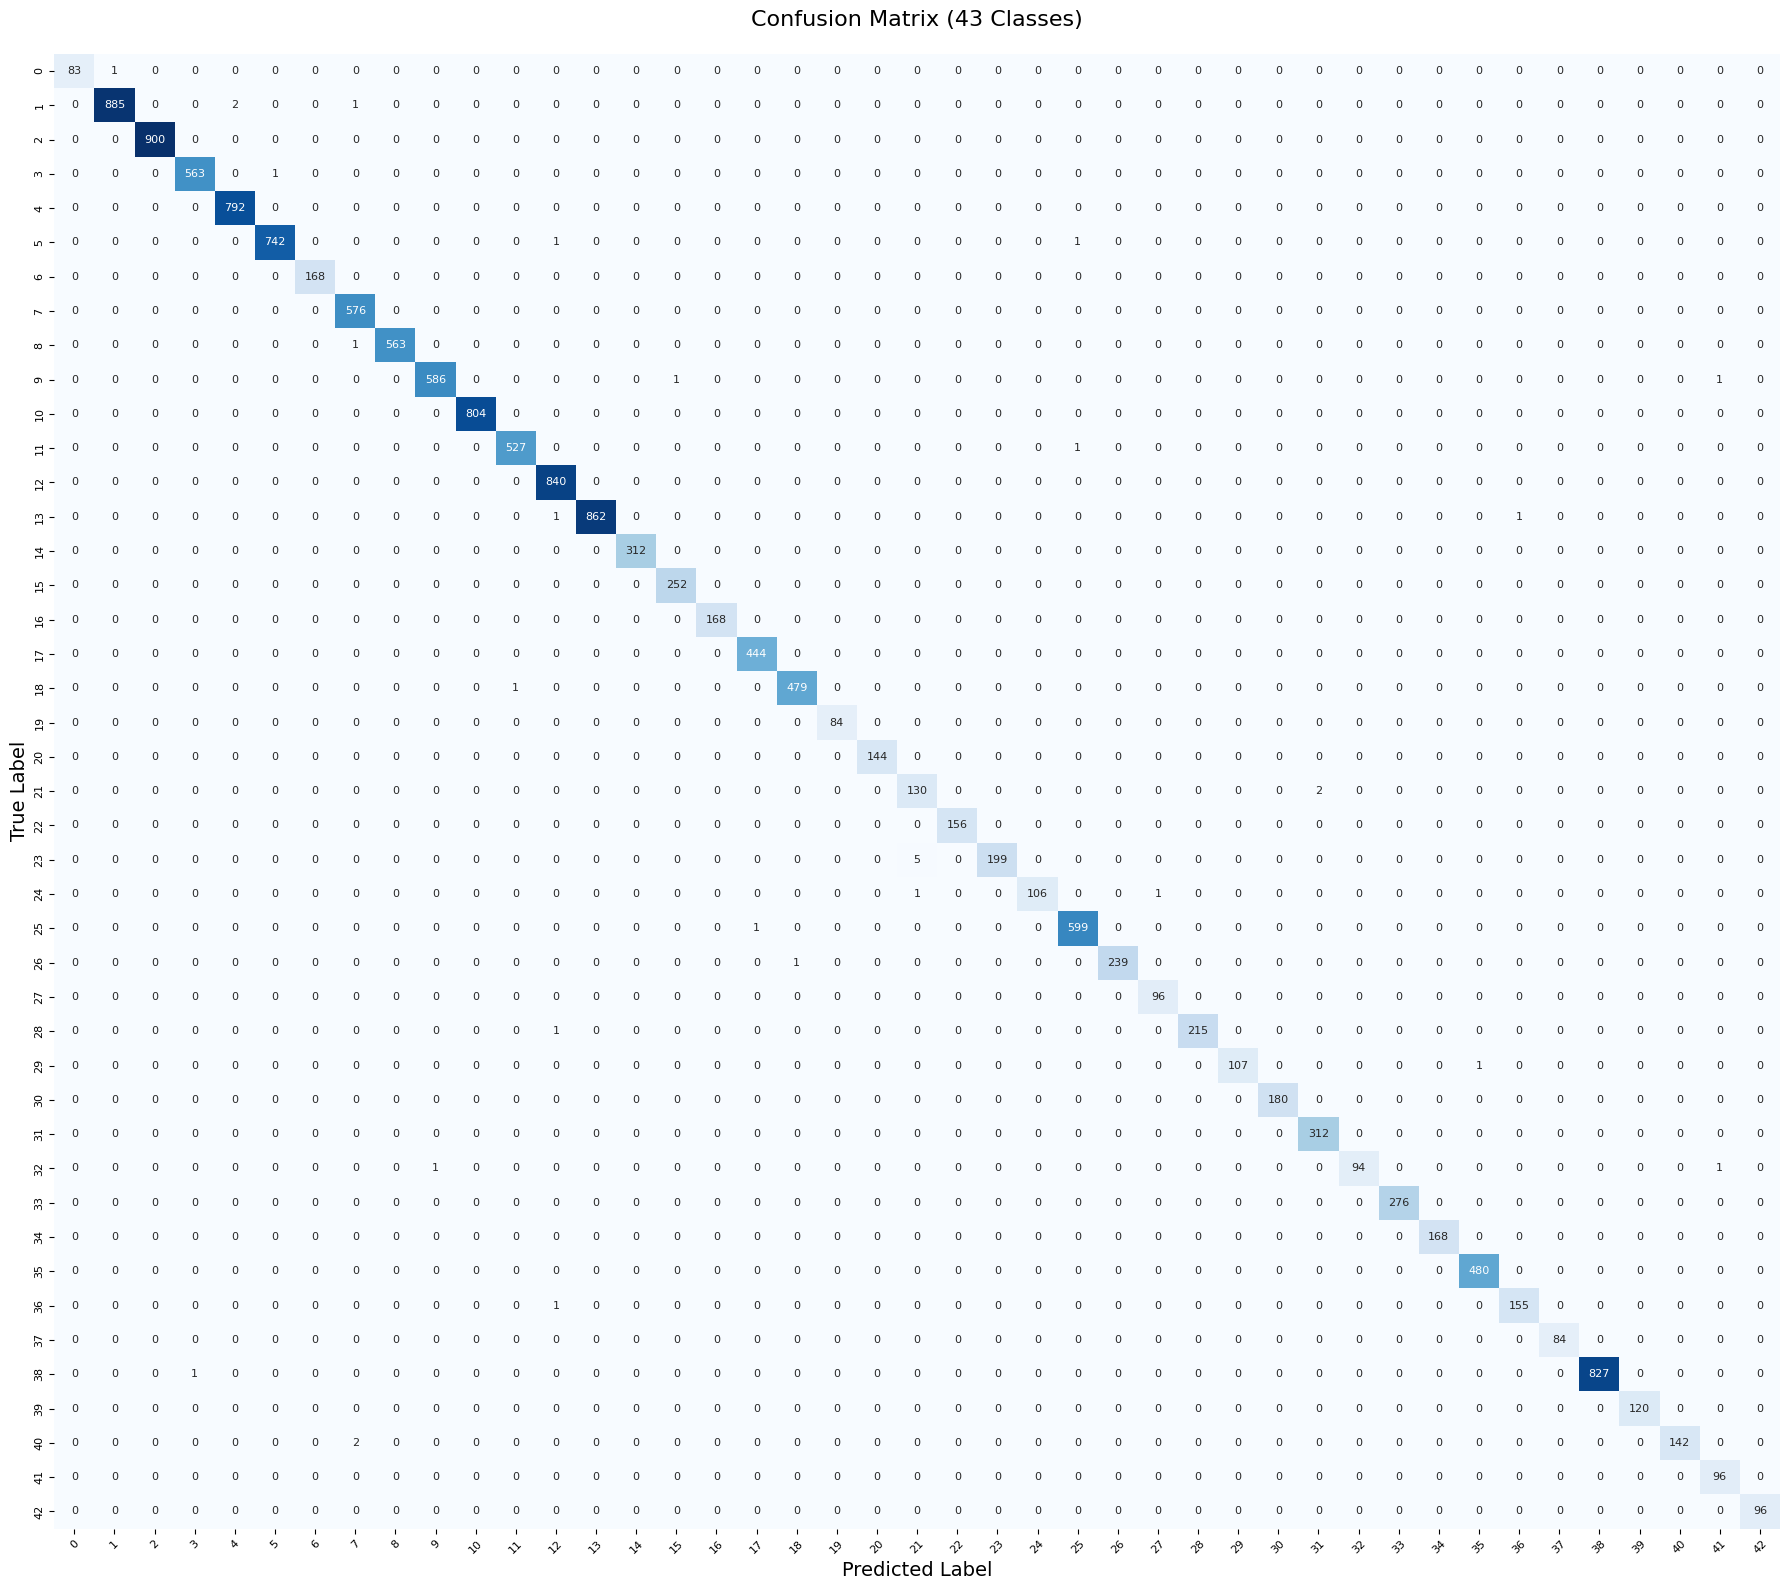

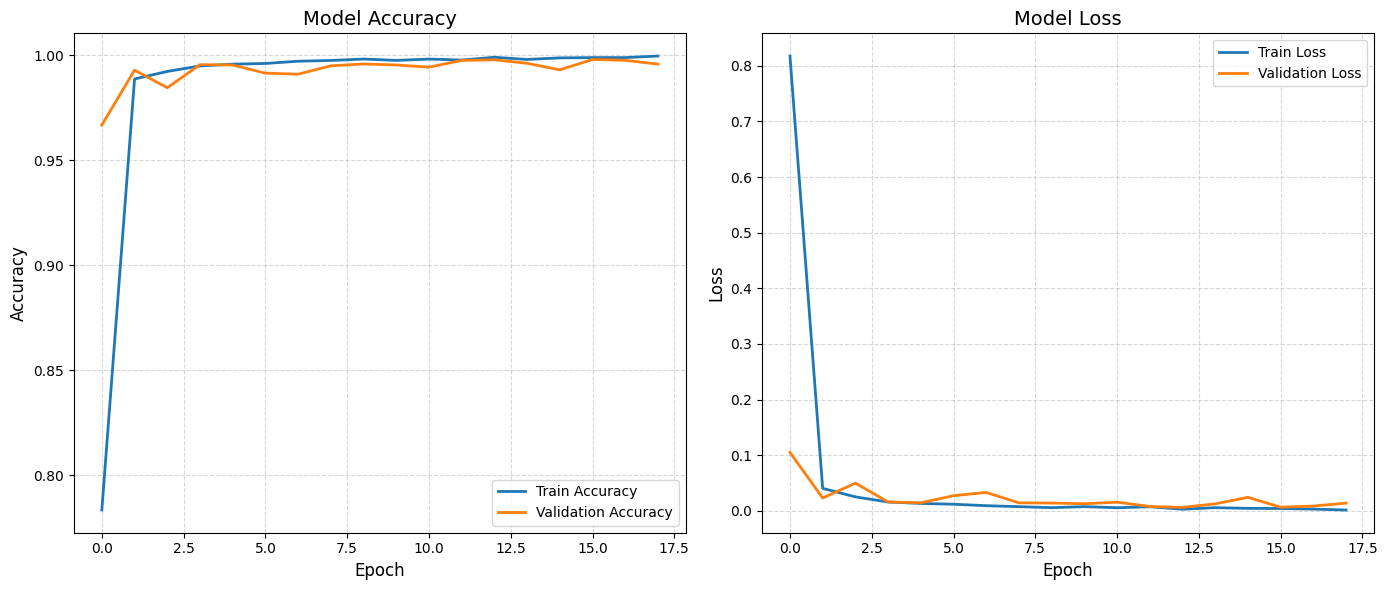

In [11]:
y_test_int = np.array(y_test).astype(int)
y_test_onehot = to_categorical(y_test_int, num_classes=43)
y_train_int = np.array(y_train).astype(int)

#training metrics
train_loss, train_acc = model.evaluate(X_train, to_categorical(y_train_int, num_classes=43), verbose=0)
y_train_pred = model.predict(X_train, verbose=0)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

#Test evaluation
test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=0)
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

#Calculate metrics
precision = precision_score(y_test_int, y_pred_classes, average='weighted')
recall = recall_score(y_test_int, y_pred_classes, average='weighted')
f1 = f1_score(y_test_int, y_pred_classes, average='weighted')

#Print metrics
print("\n" + "="*50)
print(f"{'TRAINING METRICS':^50}")
print("="*50)
print(f"{'Training Accuracy:':<25}{train_acc:.4f}")
print(f"{'Training Loss:':<25}{train_loss:.4f}\n")

print("="*50)
print(f"{'TEST METRICS':^50}")
print("="*50)
print(f"{'Test Accuracy:':<25}{test_acc:.4f}")
print(f"{'Test Loss:':<25}{test_loss:.4f}")
print(f"{'Precision:':<25}{precision:.4f}")
print(f"{'Recall:':<25}{recall:.4f}")
print(f"{'F1-Score:':<25}{f1:.4f}")
print("="*50 + "\n")

#Classification Report
print("\n" + "="*50)
print(f"{'DETAILED CLASSIFICATION REPORT':^50}")
print("="*50)
print(classification_report(y_test_int, y_pred_classes, digits=4))
print("="*50 + "\n")

#Confusion Matrix
plt.figure(figsize=(18, 16))
cm = confusion_matrix(y_test_int, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(43), yticklabels=range(43),
            annot_kws={"size": 8}, cbar=False)
plt.title('Confusion Matrix (43 Classes)', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

#Enhanced Training History Visualization
plt.figure(figsize=(14, 6))

#Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

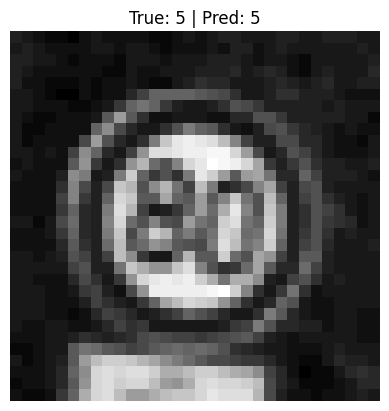

Inference time: 43.47ms
True label: 5 | Predicted: 5
Confidence: 100.00%


In [17]:
import time

def test_random_sample(model):
    idx = np.random.randint(len(augmented_I_Gray))   #Pick random index
    img, label = augmented_I_Gray[idx], augmented_L[idx]
    
    # Prepare image (add batch dim + normalize)
    x = np.expand_dims(img, axis=0)  # Shape: (1, 32, 32, 1)
    
    #Warm-up
    model.predict(x, verbose=0)
    
    #Time inference (average over 10 runs)
    times = []
    for _ in range(10):
        start = time.time()
        pred = model.predict(x, verbose=0)
        times.append(time.time() - start)
    
    avg_time = np.mean(times) * 1000  #Average all measured runs
    
    #Display
    plt.imshow(img,cmap="gray") 
    plt.title(f"True: {label} | Pred: {np.argmax(pred)}")
    plt.axis('off')
    plt.show()
    
    print(f"Inference time: {avg_time:.2f}ms")
    print(f"True label: {label} | Predicted: {np.argmax(pred)}")
    print(f"Confidence: {np.max(pred):.2%}")

test_random_sample(model)